In [48]:
# -*- coding: utf-8 -*-
"""PythonProject_Portfolio_theory.ipynb

Automatically generated by Colaboratory.

Original file is located at
    https://colab.research.google.com/drive/1eiASEwQl1PUkyfGeF5QZuUo68KB8dUYO

Python Project - Portfolio Theory

# New Section
"""

#load necessary packages
import pandas as pd 
import numpy as np
from pandas_datareader import data as pdr 
# package for dates
import datetime as dt
import matplotlib.pyplot as plt
%matplotlib inline
# Import the optimise sublibrary
import scipy.optimize as sco
import scipy.interpolate as sci

!pip install yfinance
import yfinance as yf

In [2]:
#the riskfree rate for this project is set equal to zero for simplicity:
rf=0.0

#create a stock list of which the data is retrieved
stocks=['BA','IBM','NKE','AAPL','DIS','PFE','JNJ','MCD','XOM','JPM','AXP','UNH','PG','GE','KO','CVX','CSCO','CAT','MSFT','MRK','WMT','VZ']
# change: delete 'UMX' since most pirce are missing

#set the timeframe starting in the beginning of 2018
dates=pd.date_range(start="2018-01-01",end=dt.datetime.today())

df=pdr.get_data_yahoo(stocks, start=dates[0], end=dates[-1])['Adj Close']
df.head()

Symbols,BA,IBM,NKE,AAPL,DIS,PFE,JNJ,MCD,XOM,JPM,...,PG,GE,KO,CVX,CSCO,CAT,MSFT,MRK,WMT,VZ
Date,,,,,,,,,,,,,,,,,,,,,
2018-01-02,282.886383,133.803574,61.660229,41.105534,108.726067,30.922344,128.347687,161.901535,72.152405,98.750923,...,83.115784,16.675669,41.577404,111.714676,35.458939,145.002594,82.383636,51.873783,93.182022,46.974339
2018-01-03,283.801239,137.481537,61.650509,41.098373,109.192856,31.151463,129.573715,161.219208,73.569473,98.851555,...,83.014915,16.833340,41.486099,112.529007,35.741806,145.224197,82.767044,51.799969,93.994858,46.009060
2018-01-04,282.724396,140.266037,61.611671,41.289268,109.144241,31.219345,129.564484,162.350159,73.671303,100.267670,...,83.601715,17.185772,42.070415,112.178757,35.842930,147.218613,83.495522,52.639614,94.079918,46.158237
2018-01-05,294.322296,140.951324,62.136112,41.759361,108.551003,31.278748,130.633850,162.677261,73.611900,99.623993,...,83.656731,17.195045,42.061275,111.994865,36.339340,149.545471,84.530701,52.584251,94.637550,46.052937
2018-01-08,295.570740,141.801422,62.689682,41.604263,106.994995,30.930826,130.799789,162.565094,73.942833,99.771095,...,84.096848,16.953909,41.997375,112.546539,36.716248,153.303497,84.616966,52.279762,96.036369,45.973961


In [3]:
#look if there are values missing
print(df.isnull().sum())

#drop the stock if more than 5 prices are missing, otherwise replace the missing values with the values in the previous row
df=df.dropna(axis=1,thresh=5)
stocks=df.columns
df=df.fillna(axis=1, method='ffill')
print(df.isnull().sum())

Symbols
BA      0
IBM     0
NKE     0
AAPL    0
DIS     0
PFE     0
JNJ     0
MCD     0
XOM     0
JPM     0
AXP     0
UNH     0
PG      0
GE      0
KO      0
CVX     0
CSCO    0
CAT     0
MSFT    0
MRK     0
WMT     0
VZ      0
dtype: int64
Symbols
BA      0
IBM     0
NKE     0
AAPL    0
DIS     0
PFE     0
JNJ     0
MCD     0
XOM     0
JPM     0
AXP     0
UNH     0
PG      0
GE      0
KO      0
CVX     0
CSCO    0
CAT     0
MSFT    0
MRK     0
WMT     0
VZ      0
dtype: int64


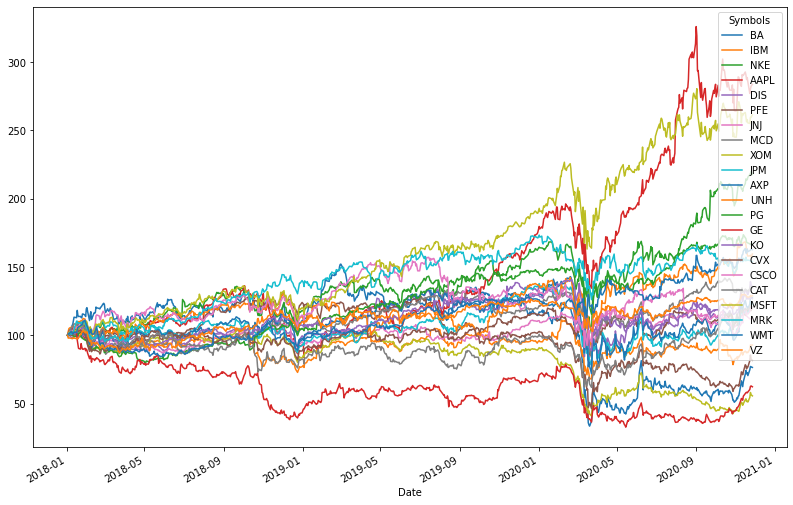

In [4]:
# Plot the 'Adj Close' value
#normalize prices first so that they start at value 100
norm=df/df.iloc[0]*100
norm.plot(kind='line', y=stocks, figsize=(13.5,9))
plt.show()

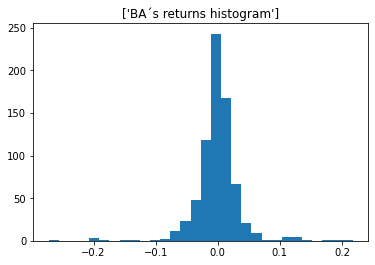

In [5]:
#Calculate log returns
ret=np.log(df/df.shift(1))
#drop missing values
ret=ret.dropna()

#plot a histogram of the first stock´s returns
plt.hist(ret[stocks[0]],bins=30)
title=['%s´s returns histogram' %stocks[0]]
plt.title(title)
plt.show()

In [6]:
#calculate annualized mean returns
avg_ret=ret.mean()*252
print(avg_ret)

#calculate a covariance matrix and variance
cov_mat=ret.cov()*252
var=ret.var()*252


Symbols
BA     -0.092075
IBM    -0.025225
NKE     0.267858
AAPL    0.358901
DIS     0.104134
PFE     0.063907
JNJ     0.039614
MCD     0.102941
XOM    -0.201449
JPM     0.070576
AXP     0.084203
UNH     0.160729
PG      0.176066
GE     -0.162542
KO      0.081610
CVX    -0.069434
CSCO    0.063972
CAT     0.064890
MSFT    0.330602
MRK     0.148536
WMT     0.167549
VZ      0.087568
dtype: float64


# Calculate the efficient frontier:
## Step 1: Calculate weight vectors for the minimum variance portfolio and the market portfolio
## Step 2: Calculate different linear combinations of those portfolios
## Step 3: Calculate returns and standard deviations of those portfolios
## Step 4: Plot the risk-return combinations of the different portfolios

In [7]:
#Step 1:

#calculate the minimum variance portfolio
#step 1: create an Nx1 vector of 1s - N is the number of stocks
ones=np.arange(len(stocks))
ones=ones.reshape(len(stocks),1)
ones[:,0]=1

#step 2: calculate a weight vector for the minimum variance portfolio
#first create a function to calculate the portfolio weights
def port_weights(covmat,returns):
  weights=np.matmul(np.linalg.inv(covmat),(returns-rf))/(np.matmul(np.matmul(np.matrix.transpose(ones),np.linalg.inv(cov_mat)),(returns-rf)))
  return(weights)

#use function to calculate minimum variance portfolio weights, use ones-vector as return and a risk-free rate of 0%
w_mvp=port_weights(cov_mat,ones)
w_mvp=np.matrix.transpose(w_mvp)
print(w_mvp)

#calculate a weight vector for the market portfolio assuming a risk-free rate of 0% using the defined function
w_mkp=port_weights(cov_mat, avg_ret)
w_mkp=np.matrix.transpose(w_mkp)
print(w_mkp)

#combine the two weight vectors to an array
w_com=np.insert(w_mvp,[1],w_mkp,axis=0)
print(w_com)

[[-0.05392116 -0.0124908   0.05559043  0.04780776  0.09681079  0.09752582
   0.12179609  0.16768215  0.09533968 -0.01648902 -0.1052237  -0.04405636
   0.00222535  0.01495598  0.08984476 -0.05718202 -0.06447792  0.01519954
  -0.08439219  0.10836615  0.18815535  0.3369333 ]]
[-0.24263426 -0.86652549  1.08221562  0.80973979  0.25955727 -0.07178535
 -1.09573052 -0.33333096 -1.68332276  0.2859232   0.34806029 -0.06055867
  0.72913548 -0.26298831  0.05405298  0.31881113 -0.7029385   0.29005485
  0.72063499  0.70860141  0.2409913   0.4720365 ]
[[-0.05392116 -0.0124908   0.05559043  0.04780776  0.09681079  0.09752582
   0.12179609  0.16768215  0.09533968 -0.01648902 -0.1052237  -0.04405636
   0.00222535  0.01495598  0.08984476 -0.05718202 -0.06447792  0.01519954
  -0.08439219  0.10836615  0.18815535  0.3369333 ]
 [-0.24263426 -0.86652549  1.08221562  0.80973979  0.25955727 -0.07178535
  -1.09573052 -0.33333096 -1.68332276  0.2859232   0.34806029 -0.06055867
   0.72913548 -0.26298831  0.0540529

In [8]:
#Step 2:
#calculate different combinations of the two portfolios

#step 1: create an array of weights for the two portfolios
lincom=np.arange(-1,2.1,0.1,dtype=float)
lincom=lincom.reshape(len(lincom),1)
lincom_flip=np.flip(lincom,0)
lincom=np.insert(lincom,[1],lincom_flip,axis=1)

#step 2: calculate weights in the stocks for the different portfolio combinations
w_port=np.matmul(lincom,w_com)

In [9]:
#Step 3:
#calculate mean returns and standard deviations of those portfolios
#mean returns:
ret_port=np.matmul(w_port,avg_ret)
ret_port=ret_port.reshape(len(ret_port),1)

#standard deviations:
std_port=np.arange(len(w_port),dtype=float)
std_port=std_port.reshape(len(std_port),1)

cov_mat_ar=cov_mat.to_numpy()
for i in range(len(w_port)):
  std_port_1=np.sqrt(np.matmul(np.matmul(w_port[i,:],cov_mat_ar),np.matrix.transpose(w_port[i,:])))
  std_port[i]=std_port_1

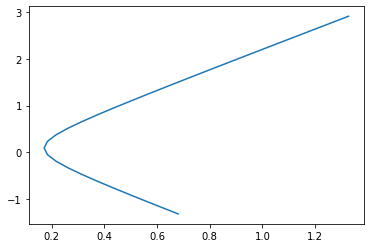

In [10]:
#Step 4:
#Create a plot of the risk-return combinations of the portfolios
plt.plot(std_port, ret_port)

### This approach allows to short certain stock. However, this results in weights which are not very applicable e.g. in the market portfolio shorting Exxon Mobile by 178%.
### Another way to calculate the efficient frontier in a more applicable way is to minimize the volatility of a portfolio given a target return under constraines (weights sum up to 1, all weights 0<=w<=1)

# Mean-Efficient Frontier

In [11]:
# Get the total number of stocks used
num_stocks = len(stocks)

# Generate 30 random weights between 0 and 1
weights = np.random.random(num_stocks)

# Constrain these weights to add up to 1
weights /= np.sum(weights)

weights

array([0.02275329, 0.0998648 , 0.04661757, 0.04776858, 0.03904243,
       0.02516849, 0.05994172, 0.07176543, 0.04168341, 0.03876233,
       0.03199915, 0.05962492, 0.07577523, 0.06999121, 0.03570501,
       0.03491195, 0.05217467, 0.0802279 , 0.01144876, 0.02350083,
       0.01062916, 0.02064319])

In [12]:
# Define a function to generate N number of random portfolios given a DataFrame of log returns
def generate_ptfs(returns, N):
    ptf_rs = []
    ptf_stds = []
    for i in range(N):
        weights = np.random.random(len(returns.columns))
        weights /= np.sum(weights)
        ptf_rs.append(np.sum(returns.mean() * weights) * 252)
        ptf_stds.append(np.sqrt(np.dot(weights.T, np.dot(returns.cov() * 252, weights))))
    ptf_rs = np.array(ptf_rs)
    ptf_stds = np.array(ptf_stds)
    return ptf_rs, ptf_stds

In [13]:
# Generate the return and volatility of 5000 random portfolios
ptf_rs, ptf_stds = generate_ptfs(ret, 5000)

Text(0.5, 1.0, '5000 Randomly Generated Portfolios In The Risk-Return Space')

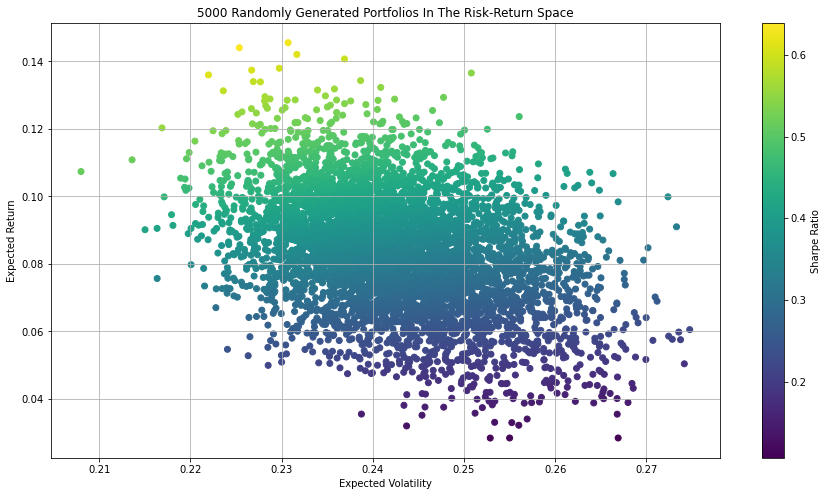

In [14]:

# Plot the 5000 randomly generated portfolio returns and volatilities and colormark the respective Sharpe ratios

plt.figure(figsize=(15, 8))
plt.scatter(ptf_stds, ptf_rs, c=(ptf_rs - rf)/ptf_stds, marker='o')
plt.grid(True)
plt.xlabel('Expected Volatility')
plt.ylabel('Expected Return')
plt.colorbar(label='Sharpe Ratio')
plt.title('5000 Randomly Generated Portfolios In The Risk-Return Space')

To find the optimal portfolios, we need to maximize the Sharpe ratio.

In [15]:
# Define a function that returns the portfolio statistics
def ptf_stats(weights):
    weights = np.array(weights)
    ptf_r = np.sum(ret.mean() * weights) * 252
    ptf_std = np.sqrt(np.dot(weights.T, np.dot(ret.cov() * 252, weights)))
    return np.array([ptf_r, ptf_std, (ptf_r - rf) / ptf_std])


# Minimise the negative value of the Sharpe ratio
def min_sharpe(weights):
    return -ptf_stats(weights)[2]

# Write the constraint that the weights have to add up to 1
cons = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})

# Bound the weights (parameter inputs) to be within 0 and 1
bnds = tuple((0, 1) for x in range(num_stocks))

In [16]:
# Starting parameter (weights) list as equal distribution
starting_ws = num_stocks * [1. / num_stocks,]

# Call the minimisation function
opts = sco.minimize(min_sharpe, starting_ws, method='SLSQP', bounds=bnds, constraints=cons)

# Inspect the results
opts

     fun: -1.117351005300796
     jac: array([ 1.68423289e+00,  9.88186762e-01, -1.86353922e-04,  8.19116831e-05,
        4.65690956e-01,  3.89930770e-01,  4.86743972e-01,  3.40762690e-01,
        1.61762634e+00,  7.08655000e-01,  7.72760063e-01,  3.66251409e-01,
       -2.31713057e-05,  1.59475882e+00,  3.07496995e-01,  1.24962200e+00,
        7.96094000e-01,  7.18572631e-01,  1.00404024e-04,  5.81102371e-02,
       -7.24643469e-05,  1.15579009e-01])
 message: 'Optimization terminated successfully'
    nfev: 185
     nit: 8
    njev: 8
  status: 0
 success: True
       x: array([3.03706345e-15, 0.00000000e+00, 1.94299746e-01, 3.17272780e-01,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 3.29783625e-17,
       2.27632293e-16, 5.30957876e-16, 5.93047595e-16, 4.25253332e-16,
       1.11249445e-01, 1.00075411e-15, 0.00000000e+00, 1.48426651e-16,
       8.70312223e-16, 0.00000000e+00, 2.32187202e-01, 0.00000000e+00,
       1.44990827e-01, 0.00000000e+00])

In [17]:
# Obtain the optimal weights
weights_opt = opts['x'].round(3)
print('optimal portfolio weights')
print(weights_opt)

# Plug optimal weights into the statistics function
print('optimal portfolio stats:')
print(ptf_stats(weights_opt))

optimal portfolio weights
[0.    0.    0.194 0.317 0.    0.    0.    0.    0.    0.    0.    0.
 0.111 0.    0.    0.    0.    0.    0.232 0.    0.145 0.   ]
optimal portfolio stats:
[0.28627364 0.25620745 1.11735097]


Next, we can obtain the absolute minimum variance portfolio. As the name suggests, in order to obtain this portfolio, we minimise the portfolio variance.

For the absolute minimum variance portfolio, more portflios are invested in or, put differently, there are less stocks with weighst of zero.

In [18]:
# Define a function that minimises portfolio variance
def min_var(weights):
    # Remember that variance is just standard deviation (volatility) squared
    return ptf_stats(weights)[1]**2

In [19]:
# Call the optimisation fcuntion
opt_var = sco.minimize(min_var, starting_ws, method='SLSQP', bounds=bnds, constraints=cons)
print(opt_var)

     fun: 0.0323875201899194
     jac: array([0.09441579, 0.07193528, 0.06477609, 0.07010024, 0.06486246,
       0.06478791, 0.06461879, 0.06483478, 0.06767062, 0.0782272 ,
       0.08550278, 0.07767442, 0.06479502, 0.07296067, 0.06474135,
       0.07897255, 0.07472207, 0.07054574, 0.07710182, 0.0649956 ,
       0.06471976, 0.06476543])
 message: 'Optimization terminated successfully'
    nfev: 322
     nit: 14
    njev: 14
  status: 0
 success: True
       x: array([0.00000000e+00, 4.47326459e-18, 5.29422928e-03, 0.00000000e+00,
       9.46012929e-03, 5.39105188e-02, 8.07903973e-02, 8.98427632e-02,
       3.18919030e-19, 2.05112638e-18, 4.49239002e-18, 8.81044233e-18,
       1.95799875e-02, 1.62069213e-18, 6.04832777e-02, 2.32814900e-18,
       8.25564147e-18, 6.36416316e-18, 1.04264478e-17, 1.02250051e-01,
       2.10601598e-01, 3.67787048e-01])


In [24]:
# Obtain the optimal weights
weights_opt_var = opt_var['x'].round(3)
print('optimal portfolio weights (absolute minimum variance):')
print(weights_opt_var)

# Get the statistics for the absolute minimum variance portfolio
print('optimal portfolio stats (absolute minimum variance):')
print(ptf_stats(weights_opt_var))

optimal portfolio weights (absolute minimum variance):
[0.    0.    0.005 0.    0.009 0.054 0.081 0.09  0.    0.    0.    0.
 0.02  0.    0.06  0.    0.    0.    0.    0.102 0.211 0.368]
optimal portfolio stats (absolute minimum variance):
[0.10934739 0.17996515 0.6076031 ]


In [25]:
# Set up two conditions, one for the target return level and one for the sum of the portfolio weights
cons2 = ({'type': 'eq', 'fun': lambda x: ptf_stats(x)[0] - r},
        {'type': 'eq', 'fun': lambda x: np.sum(x) - 1})

# The boundary condition stays the same
bnds2 = tuple((0, 1) for x in weights)

# Define a function that returns the volatility of a portfolio given a vector of weights
def min_port(weights):
    return ptf_stats(weights)[1]

In [43]:
# Define a function to get the target returns and volatilities given a range of returns
def efficient_frontier(start_r, end_r, steps):
    target_rs = np.linspace(start_r, end_r, steps)
    target_stds = []
    for r in target_rs:
        cons2 = ({'type': 'eq', 'fun': lambda x: ptf_stats(x)[0] - r},
                {'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
        bnds2 = tuple((0, 1) for x in weights)
        res = sco.minimize(min_port, starting_ws, method='SLSQP', bounds = bnds2, constraints=cons2)
        target_stds.append(res['fun'])
    target_stds = np.array(target_stds)
    return target_rs, target_stds

In [44]:
# Obtain the target returns and volatilities based on 50 target returns
target_rs, target_stds = efficient_frontier(0.0, 0.30, 50)

Text(0.5, 1.0, 'Efficient Frontier')

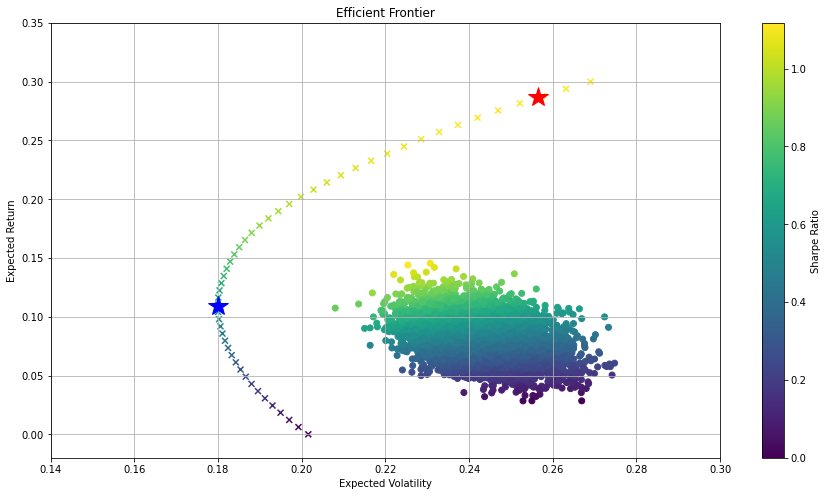

In [47]:
# Plot the efficient frontier in the same visualisation as the randomly generated portfolios
plt.figure(figsize=(15, 8))
plt.scatter(ptf_stds, ptf_rs, c=(ptf_rs - rf)/ptf_stds, marker='o')
plt.scatter(target_stds, target_rs, c=(target_rs - rf)/target_stds, marker='x')
plt.plot(ptf_stats(opts['x'])[1], ptf_stats(opts['x'])[0], 'r*', markersize=20.0)
plt.plot(ptf_stats(opt_var['x'])[1], ptf_stats(opt_var['x'])[0], 'b*', markersize=20.0)
plt.grid(True)
plt.xlabel('Expected Volatility')
plt.ylabel('Expected Return')
plt.xlim(0.14, 0.3)
plt.ylim(-0.02,0.35)
plt.colorbar(label='Sharpe Ratio')
plt.title('Efficient Frontier')

The blue star depicts the absolute minimum variance portfolio and the red star depicts the absolute maximum Sharpe ratio portfolio.

# Capital Market Line

In [61]:
# Select the index of the absolute minimum variance portfolio
min_var = np.argmin(target_stds)

# Select expected volatilities for the stocks on the efficient frontier
ex_stds = target_stds[min_var:]

# Select expected returns for the stocks on the efficient frontier
ex_rs = target_rs[min_var:]

# Interpolate the B-spline representation of the data points
tck = sci.splrep(ex_stds, ex_rs)


# Obtain coordinates to be used for plotting the B-spline interpolation of the efficient frontier
x_lower = min(ex_stds)
x_upper = max(ex_stds)
x_range = np.linspace(x_lower, x_upper, 500)
bspline = sci.splev(x_range, tck)

Text(0.5, 1.0, 'Efficient Frontier')

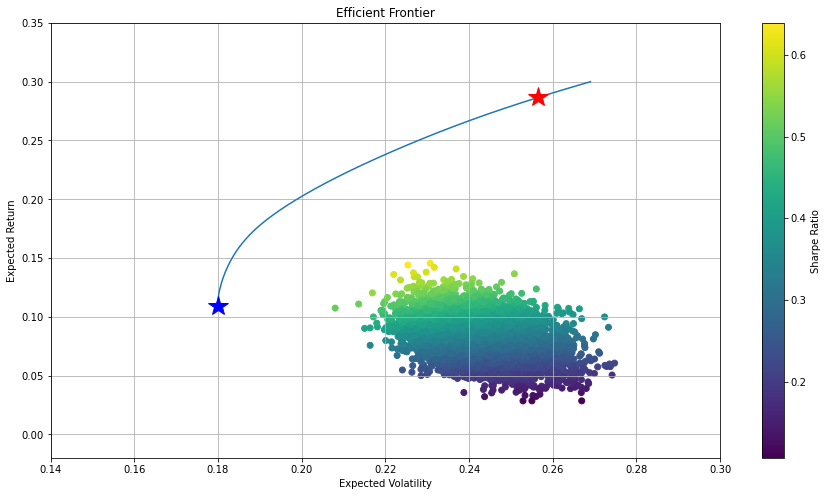

In [52]:
# Plot the efficient frontier in the same visualisation as the randomly generated portfolios
plt.figure(figsize=(15, 8))
plt.scatter(ptf_stds, ptf_rs, c=(ptf_rs - rf)/ptf_stds, marker='o')
plt.plot(x_range, bspline)
plt.plot(ptf_stats(opts['x'])[1], ptf_stats(opts['x'])[0], 'r*', markersize=20.0)
plt.plot(ptf_stats(opt_var['x'])[1], ptf_stats(opt_var['x'])[0], 'b*', markersize=20.0)
plt.grid(True)
plt.xlabel('Expected Volatility')
plt.ylabel('Expected Return')
plt.xlim(0.14, 0.3)
plt.ylim(-0.02,0.35)
plt.colorbar(label='Sharpe Ratio')
plt.title('Efficient Frontier')

In [62]:
# Define a continuously differentiable function f(x) for the efficient frontier
def f(x):
    return sci.splev(x, tck, der=0)

# Define the first derivate function of f(x)
def df(x):
    return sci.splev(x, tck, der=1)


def cml_conditions(p, rf=0.00):
    eq1 = rf - p[0]
    eq2 = rf + p[1] * p[2] - f(p[2])
    eq3 = p[1] - df(p[2])
    return eq1, eq2, eq3

# Solve for the parameters of the Capital Market Line
cml = sco.fsolve(cml_conditions, [0, 0.5, 0.15])

# Create input variable for CML
cx = np.linspace(0.0, 0.3)

Text(0.5, 1.0, 'Efficient Frontier')

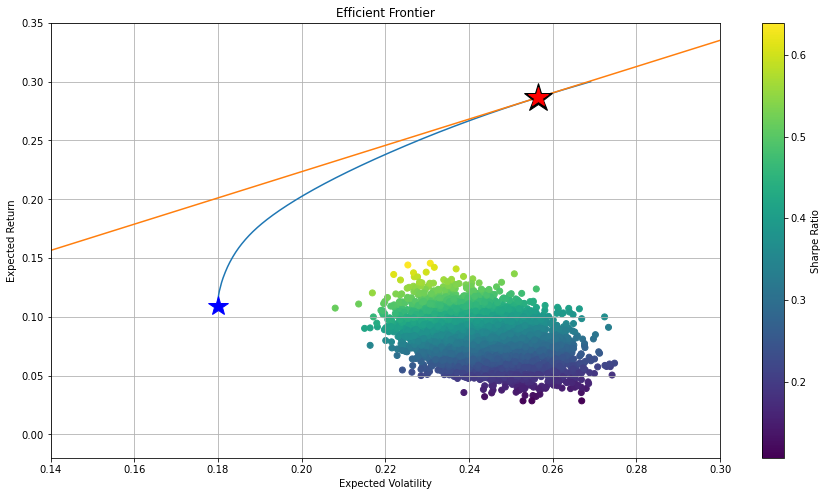

In [75]:
# Plot the efficient frontier in the same visualisation as the randomly generated portfolios
plt.figure(figsize=(15, 8))
plt.scatter(ptf_stds, ptf_rs, c=(ptf_rs - rf)/ptf_stds, marker='o') # Random portfolios
plt.plot(x_range, bspline, label='Efficient Frontier') # Efficient Frontier
plt.plot(cx, cml[0] + cml[1] * cx, lw=1.5, label='Capital Market Line') # Capital Market Line
plt.plot(cml[2], f(cml[2]), 'k*', markersize=30.0) # Optimal portfolio where the tangent line passes through rf
plt.plot(ptf_stats(opts['x'])[1], ptf_stats(opts['x'])[0], 'r*', markersize=20.0)
plt.plot(ptf_stats(opt_var['x'])[1], ptf_stats(opt_var['x'])[0], 'b*', markersize=20.0)
plt.grid(True)
plt.xlabel('Expected Volatility')
plt.ylabel('Expected Return')
plt.xlim(0.14, 0.3)
plt.ylim(-0.02,0.35)
plt.colorbar(label='Sharpe Ratio')
plt.title('Efficient Frontier')